# Course: DD2424 - Assignment 3

In [1]:
import numpy as np
import _pickle as cPickle
import matplotlib.pyplot as plt

Computation of gradients

In [2]:
# Compute the gradients of the cost function for a mini-batch    
def ComputeGradients(X, y, Y, W, B, lamda, mode):
    
    grad_W=np.copy(W)*0
    grad_B=np.copy(B)*0
    
    batchSize=len(y)
    
    # moving forwand     
    LayerPass, LayerAct ,s , sCent,M ,V= BN_FWD(X, W, B, mode, status='leaky')

    g=0.

    # moving backwards
    for i in reversed(range(len(W))):
        if i == len(W)-1:
            p=LayerAct[i]
            hEnd=LayerAct[i-1]
            g=p - Y
            grad_B[i] += np.expand_dims(np.sum(g,axis=1),1)
            grad_W[i] += np.dot(g,hEnd.T)
        elif i>0 and i<len(W)-1:
            g=np.dot(g.T,W[i+1])
            if mode is 'ReLu':
                ind=1*(LayerPass[i]>0)
            elif mode is 'LeakyReLu':
                ind=(LayerPass[i]>0)*1+(LayerPass[i]<0)*0.01
            g=(g*ind.T).T

            g=BatchNormBackPass(g,s[i],sCent[i],V[i])

            grad_B[i] += np.expand_dims(np.sum(g,axis=1),1)
            grad_W[i] += np.dot(g,LayerAct[i-1].T)
        elif i==0:
            g=np.dot(g.T,W[i+1])
            if mode is 'ReLu':
                ind=1*(LayerPass[i]>0)
            elif mode is 'LeakyReLu':
                ind=(LayerPass[i]>0)*1+(LayerPass[i]<0)*0.01
            g=(g*ind.T).T
            g=BatchNormBackPass(g,s[i],sCent[i],V[i])
            grad_B[0] += np.expand_dims(np.sum(g,axis=1),1)
            grad_W[0] += np.dot(g,X.T)   
        
    #Divide by the number of entries in batch to get average
    grad_W /= batchSize
    grad_B /= batchSize
    # Add the gradient for the regularization term
    grad_W += 2*lamda*np.copy(W)
    grad_B += 2*lamda*np.copy(B)
    
    return grad_W, grad_B ,M ,V

The Mini-Batch algo

In [3]:
# the minibatch algithm
def MiniBatchGD(X, y, Y, W, B, Vx, Vy, VY, GDparams, mode):
    
    # Create the v matrices
    vW, vB = np.copy(W)*0, np.copy(B)*0
    
    # define statistic lists
    lossOnTrain=[]
    lossOnValidation=[]
    costOnTrain=[]
    costOnValidation=[]
    accuracyOnTrain=[]
    accuracyOnValidation=[]
    storedW=[]
    storedB=[]
    Mean=[]
    Std=[]
    
    #Compute initial stats for thaining and validation set
    loss, cost, accuracy = ComputeStats(X, y, Y, W, B, GDparams.lamda, mode)
    lossOnTrain.append(loss)
    costOnTrain.append(cost)
    accuracyOnTrain.append(accuracy)
    loss, cost, accuracy = ComputeStats(Vx, Vy, VY, W, B, GDparams.lamda, mode)
    lossOnValidation.append(loss)
    costOnValidation.append(cost)
    accuracyOnValidation.append(accuracy)
    
    alpha = 0.99
    
    #start mini-batch
    for epoch in range(GDparams.n_epochs):
        i=0 
#         print(accuracyOnValidation[epoch])
        if RandOrder is 'on' and epoch > 1:
            reOrder = np.random.permutation(len(y))
            X=X[:,reOrder] 
            Y=Y[:,reOrder]
            y=y[reOrder] 

        while i<len(X.T):
            ### create batch
            if i+GDparams.n_batch > len(y):
                Xbatch=X[:,i:len(y)]
            else:
                Xbatch=X[:,i:i+GDparams.n_batch]
            if i+GDparams.n_batch > len(y):
                Ybatch=Y[:,i:len(y)]
            else:
                Ybatch=Y[:,i:i+GDparams.n_batch] 
            if i+GDparams.n_batch > len(y):
                ybatch=y[i:len(y)]
            else:
                ybatch=y[i:i+GDparams.n_batch] 
            
            if Jitter is 'on' and epoch > 1:
                jitterMask= np.random.normal(0, 0.00005 * np.std(Xbatch) ,Xbatch.shape)
                Xbatch +=   jitterMask
            
            #-----> TRAIN BATCH ->            
            grad_W, grad_B , Mu, sDev= ComputeGradients(Xbatch, ybatch, Ybatch, W, B, GDparams.lamda, mode) 
            
            # Exponential moving average for batch means and variances
            if i==0:
                CurrentMean,CurrentStd = Mu, sDev
            else:
                CurrentMean = alpha * np.copy(Mu) + (1-alpha) * np.copy(CurrentMean)
                CurrentStd = alpha * np.copy(sDev) + (1-alpha) * np.copy(CurrentMean)
            
            # update weights
            W, B, vW, vB = WeightUpdate(Xbatch, ybatch, Ybatch, W, B, grad_W, grad_B, GDparams, vW, vB, mode)
            # fix bug with chaning values
            if Jitter is 'on' and epoch > 1:
                X[:,i:i+GDparams.n_batch] -=   jitterMask
            #move to the next batch
            i+=GDparams.n_batch

        
        #set drop learing rate to on or off
        if DropRate=='on':
            GDparams.eta-=GDparams.eta-GDparams.eta*0.9
            
        #Compute stats for thaining and validation set durring learning       
        Mean.append(CurrentMean)
        Std.append(CurrentStd)
        loss, cost, accuracy = ComputeStats_T(X, y, Y, W, B, GDparams.lamda, mode, CurrentMean, CurrentStd) 
        lossOnTrain.append(loss)
        costOnTrain.append(cost)
        accuracyOnTrain.append(accuracy)
        loss, cost, accuracy = ComputeStats_T(Vx, Vy, VY, W, B, GDparams.lamda, mode, CurrentMean, CurrentStd) 
        lossOnValidation.append(loss)
        costOnValidation.append(cost)
        accuracyOnValidation.append(accuracy)

        # store the weights
        storedW.append(W)
        storedB.append(B)
        
        #set early stopping
        if EarlyStop is 'on' and epoch > 10 :
            TrackAcc=np.average(accuracyOnValidation[epoch-10:epoch])
            if TrackAcc > accuracyOnValidation[epoch+1]:
                break
        
        #set breaking point for the training/validating cost exploding
        if costOnTrain[epoch+1] > 3 * costOnTrain[0] or costOnValidation[epoch+1] > 3 *costOnValidation[0]:
            break
    BestIter=np.argmax(accuracyOnValidation)
    
    return storedW[BestIter-1], storedB[BestIter-1],\
            lossOnTrain, lossOnValidation, costOnTrain, costOnValidation, accuracyOnTrain, accuracyOnValidation, BestIter,\
                Mean[BestIter-1], Std[BestIter-1]

The random Grid Search for hyperparameters and network architecture

In [4]:
#Grid search for hyperparameters of the network
def GridSearch(X, y, Y, W, B, Vx, Vy, VY, SearchMode, mode, gridSize):
    
    if SearchMode is 'extended':
        #initialize big random grid
        e=np.random.uniform(0,5,gridSize)
        etaRandBig=10**(-e)
        e=np.random.uniform(0,6,gridSize)
        lamdaRandBig=10**(-e)

        BigSearchAccuracy=np.zeros((gridSize,gridSize))#*np.nan
        i=0
        for lamda in lamdaRandBig:
            j=0
            for eta in etaRandBig:
                BigSearchParams=GDparams(lamda, 10, 100, eta)
                _, _, _, _, _, _, _, accuracyOnValidationTemp, _, _, _= \
                                    MiniBatchGD(X, y, Y, np.copy(W), np.copy(B)\
                                                , Vx, Vy, VY, BigSearchParams, mode)
                BigSearchAccuracy[i,j]=np.asarray(accuracyOnValidationTemp).max()
                print(lamda,eta,BigSearchAccuracy[i,j])
                j+=1
                
            i+=1

        bestLamdaIndex,bestEtaIndex=np.unravel_index(BigSearchAccuracy.argmax(),BigSearchAccuracy.shape)
        bestLamda=lamdaRandBig[bestLamdaIndex]
        bestEta=etaRandBig[bestEtaIndex]
        bestValue=np.max(BigSearchAccuracy)
        # visualize Big Random grid
        plt.pcolor(lamdaRandBig, etaRandBig, BigSearchAccuracy, cmap='cool')
        plt.xlabel('lambda')
        plt.ylabel('eta')
        plt.colorbar()
        plt.savefig('results/BigGridEvalParams.png', bbox_inches='tight')
        plt.show()
        
        #Search around optimal area
        exGridEta=np.random.normal(bestEta,bestEta/2,gridSize)
        exGridLamda=np.random.normal(bestLamda,bestLamda/2,gridSize)

        ExtaAccuracy=np.zeros((gridSize,gridSize))#*np.nan
        i=0
        for lamda in exGridLamda:
            j=0
            for eta in exGridEta:
                if lamda>=0 and eta>0:
                    extSearchParams=GDparams(lamda, 5, 100, eta)
                    _, _, _, _, _, _, _,ExtAccuracyOnValidationTemp, _, _, _= \
                                        MiniBatchGD(X, y, Y, np.copy(W), np.copy(B),\
                                                    Vx, Vy, VY, extSearchParams, mode)
                    ExtaAccuracy[i,j]=np.asarray(ExtAccuracyOnValidationTemp).max()
                    print(lamda,eta,ExtaAccuracy[i,j])
                    j+=1
                else:
                    j+=1 
            i+=1
        ExtbestLamdaIndex,ExtbestEtaIndex=np.unravel_index(ExtaAccuracy.argmax(),ExtaAccuracy.shape)
        ExtBestLamda=exGridLamda[ExtbestLamdaIndex]
        ExtBestEta=exGridEta[ExtbestEtaIndex]
        ExtBestValue=np.max(ExtaAccuracy)
        # visualize extended Random grid
        plt.pcolor(exGridLamda, exGridEta, ExtaAccuracy, cmap='cool')
        plt.xlabel('lambda')
        plt.ylabel('eta')
        plt.colorbar()
        plt.savefig('resultsExtendedGridEvalParams.png', bbox_inches='tight')
        plt.show()

        if ExtBestValue>bestValue:
            bestLamda=ExtBestLamda
            bestEta=ExtBestEta
            bestValue=ExtBestValue
            
    elif SearchMode is 'predefined':
        #predefined optimal values
        bestEta=0.05
        bestLamda=1e-05

        GridEta=np.random.normal(bestEta,bestEta/5,gridSize)
        GridLamda=np.random.normal(bestLamda,bestLamda/1,gridSize)

        BigSearchAccuracy=np.zeros((gridSize,gridSize))#*np.nan
        i=0
        for lamda in GridLamda:
            j=0
            for eta in GridEta:
                if lamda>=0 and eta>0:
                    SearchParams=GDparams(lamda, 10, 100, eta)
                    _, _, _, _, _, _, _, AccuracyOnValidationTemp, _, _, _= \
                                MiniBatchGD(X, y, Y, np.copy(W), np.copy(B)\
                                            , Vx, Vy, VY, SearchParams, mode)
                    BigSearchAccuracy[i,j]=np.asarray(AccuracyOnValidationTemp).max()
                    print(lamda,eta,BigSearchAccuracy[i,j])
                    j+=1
                else:
                    j+=1 
            i+=1
        bestLamdaIndex,bestEtaIndex=np.unravel_index(BigSearchAccuracy.argmax(),BigSearchAccuracy.shape)
        bestLamda=GridLamda[bestLamdaIndex]
        bestEta=GridEta[bestEtaIndex]
        bestValue=np.max(BigSearchAccuracy)
        # visualize grid
        plt.pcolor(GridLamda, GridEta, BigSearchAccuracy, cmap='cool')
        plt.xlabel('lambda')
        plt.ylabel('eta')
        plt.colorbar()
        plt.savefig('results/predefinedGridEvalParams.png', bbox_inches='tight')
        plt.show()
        ExtaAccuracy = BigSearchAccuracy
    
    
    #run for 20 epochs with the optimal values    
    paramsOpt=GDparams(bestLamda, 20, 100, bestEta)     
    optW, optB, optlossOnTrain, optlossOnValidation, optcostOnTrain, optcostOnValidation,\
        optaccuracyOnTrain, optaccuracyOnValidation, optBestIter, OptBestMu, OptBestVar= \
                MiniBatchGD(X, y, Y, np.copy(W), np.copy(B), Vx, Vy, VY, paramsOpt, mode)
    print('The best accuracy %s is retrieved with lamda=%s and eta=%s'%(np.max(optaccuracyOnValidation)*100,bestLamda,bestEta))

    #plot optimal learning stats
    LearningStats(paramsOpt,optlossOnTrain, optlossOnValidation,optcostOnTrain, optcostOnValidation,\
                  optaccuracyOnTrain, optaccuracyOnValidation,'OptGridRandSrc')
    VisWeights(optW[0],paramsOpt,'GridSearch')
    
    return bestLamda, bestEta, np.max(optaccuracyOnValidation), BigSearchAccuracy, ExtaAccuracy


# Search for best network architecture
def ArchSearch(X, y, Y, Vx, Vy, VY, mode, MinLayers, MaxLayers):
    np.random.seed()
    NetSearchAc=[]
    NetSearchArch=[]
    NetSearchEta=[]
    count=0
    for layers in range(MinLayers,MaxLayers):
        nets=[25,50,100,150,200]
        for nodes in range(int(layers*6)):
            tempNetArchitecture=np.random.choice(nets,layers).tolist()
            if count>0 and CompareList(NetSearchArch,tempNetArchitecture) is True:
                continue
            # initialize the weights
            TempW, TempB =InstallWeights(X,Y,tempNetArchitecture)
            GridEta=np.random.normal(0.05,0.05/5,5)
            EtaSearchAc=[]
            for eta in GridEta:
                TempParams= GDparams(0, 10, 100, eta)
                TempX =np.copy(X)
                _, _, _, _, _, _, _, accuracyOnValidationTemp, _, _, _= \
                                        MiniBatchGD(TempX, y, Y, np.copy(TempW), np.copy(TempB)\
                                                    , Vx, Vy, VY, TempParams, mode)
                EtaSearchAc.append(np.max(accuracyOnValidationTemp))
            TempBestACC=np.max(EtaSearchAc)
            TempBestEta=GridEta[(np.argmax(EtaSearchAc))]
            NetSearchArch.append(tempNetArchitecture[1:-1])
            NetSearchAc.append(TempBestACC)
            NetSearchEta.append(TempBestEta)
            print("%s, with net arch:%s and eta = %s"%(TempBestACC,tempNetArchitecture[1:-1],TempBestEta))
            count+=1
    
    bestAcuracy=np.max(NetSearchAc)
    bestNet=NetSearchArch[np.argmax(NetSearchAc)]
    bestEta=NetSearchEta[np.argmax(NetSearchAc)]
    print("The Search is done with:")
    print("The best Accuracy = %s"%bestAcuracy)
    print("For the Net = %s"%bestNet)
    print("With best Eta = %s"%bestEta)
    NetStats=(NetSearchAc, NetSearchEta, NetSearchArch)
    
    return NetStats

weight update

In [5]:
# different wheight update manners
def WeightUpdate(X, y, Y, W, B, grad_W, grad_B, GDparams, vW, vB, mode):
    
    gamma=0.9

    if UpdateMode is 'Simple':
        # Simple subtraction of the gradient
        
        W = np.copy(W) - GDparams.eta * np.copy(grad_W)
        B = np.copy(B) - GDparams.eta * np.copy(grad_B)
        
    elif UpdateMode is 'Momentum':
        # SGD with momentum
        
        vW = gamma * np.copy(vW) + GDparams.eta * np.copy(grad_W)
        vB = gamma * np.copy(vB) + GDparams.eta * np.copy(grad_B)
        
        W = np.copy(W) - vW
        B = np.copy(B) - vB

    elif UpdateMode is 'NAG':
        # Nesterov accelerated gradient

        We = np.copy(W) - gamma * np.copy(vW)
        Be = np.copy(B) - gamma * np.copy(vB)

        grad_We, grad_Be , Mu, sDev = ComputeGradients(X, y, Y, We, Be, GDparams.lamda, mode)

        vW = gamma* np.copy(vW) + GDparams.eta * grad_We
        vB = gamma* np.copy(vB) + GDparams.eta * grad_Be

        W = np.copy(W)- vW
        B = np.copy(B)- vB
    
    return W, B, vW, vB

Numeciral computation and comparison of gradients

In [6]:
# Gradiants numerical computation
def ComputeGradsNumSlow(X, y, Y, W, B, lamda, mode, h=10**(-7)):

    # initialize gradients
    grad_W=np.copy(W)*0
    grad_B=np.copy(B)*0
    
    for weights in range(len(W)):
        
        # compute gradients for bias       
        for i in range(len(B[weights])):
            b_try = np.copy(B)
            b_try[weights][i] -= h
            _, c1, _=ComputeStats(X, y, Y, W, b_try, lamda, mode)
            b_try[weights][i] += h
            b_try = np.copy(B)
            b_try[weights][i] += h
            _, c2, _=ComputeStats(X, y, Y, W, b_try, lamda, mode)
            b_try[weights][i] -= h
            grad_B[weights][i] = (c2-c1) / (2*h)

        # compute gradients for weights 
        for i in range(len(W[weights])):
            for j in range(len(W[weights].T)):
                W_try = np.copy(W)
                W_try[weights][i,j] -= h
                _, c1, _=ComputeStats(X, y, Y, W_try, B, lamda, mode)
                W_try[weights][i,j] += h
                W_try = np.copy(W)
                W_try[weights][i,j] += h
                _, c2, _=ComputeStats(X, y, Y, W_try, B, lamda, mode)
                W_try[weights][i,j] -= h
                grad_W[weights][i,j] = (c2-c1) / (2*h);
            
    return grad_W, grad_B

# Compute the gradients numerically of the cost function for a mini-batch    
def ComputeGradientsNum(X, y, Y, W, B, lamda, mode):
    grad_W=np.copy(W)*0
    grad_B=np.copy(B)*0
    batchSize=len(y)
    for i in range(batchSize):
        grad_W_num, grad_B_num =ComputeGradsNumSlow(X.astype(float),y, Y, W,B, lamda, mode)
        grad_W +=grad_W_num
        grad_B +=grad_B_num
        
    #Divide by the number of entries in batch to get average
    grad_W /= batchSize
    grad_B /= batchSize
    
    return grad_W, grad_B

def ComputeGradDiff(X, y, Y, W, B, lamda, mode):
    #compute gradients numericaly
    grad_W_num, grad_B_num =ComputeGradientsNum(X, y, Y, W, B, lamda, mode)
    #compute gradients analyticaly
    grad_W_an, grad_B_an =ComputeGradients(X, y, Y, W, B, lamda, mode)
    #compute difference
    for i in reversed(range(len(W))):
        diffW=np.abs(grad_W_an[i]-grad_W_num[i])/np.max((np.abs(grad_W_an[i])+np.abs(grad_W_num[i])).clip(0))
        diffB=np.abs(grad_B_an[i]-grad_B_num[i])/np.max((np.abs(grad_B_an[i])+np.abs(grad_B_num[i])).clip(0))
        diff=(diffW.mean()+diffB.mean())/2.
        print('In the %s layer the Numerical to Analytical difference of the Grads is %s'%(i+1,diff))
        print('with %s being the difference in Ws'%diffW.mean())

Several functions for the algorithm

In [7]:
# the object for the parameters of the minibatch
class GDparams(object):
    def __init__(self, lamda, n_epochs, n_batch, eta):
        self.lamda=lamda
        self.n_epochs=n_epochs
        self.n_batch=n_batch
        self.eta=eta

# a list comparison function
def CompareList(list1, list2):
    for val in list1:
        if val == list2:
            return True
    return False


# READ THE DATA function
def LoadBatch(filename):
    #read the data from a CIFAR-10 batch file and return the image and label data in separate files
    #this function is adopted from the source: https://github.com/PaddlePaddle/Paddle/issues/1301

    f = open(filename, 'rb')
    d = cPickle.load(f, encoding='bytes')
    d_decoded = {}
    for k, v in d.items():
        d_decoded[k.decode('utf8')] = v
    d = d_decoded
    f.close()
    data = d['data']
    labels = d['labels']
    filenames = [b.decode("utf-8") for b in d['filenames']]

    return data, labels, filenames


# preprocessing of the data to have 0 mean 
# and subtraction of this mean form the test and validation set
def PreProcessing(train, val, test):
    inSize=len(train.T)
    if inSize is not 1:
        TrainSetMean=np.expand_dims(np.mean(train,axis=1),1)
        train -=TrainSetMean
        val -=TrainSetMean
        test -=TrainSetMean
        
        return train, val, test
    else:
        return train, val, test


# Convert to One Hot Representation
def OneHotRep(labels):
    oneHot=np.zeros((len(labels),np.max(labels)+1))
    oneHot[np.arange(len(labels)), labels] = 1
    
    return oneHot

# weight initialization
def InstallWeights(X,Y,NetArch):
    NetArch.insert(0,len(X))
    NetArch.append(len(Y))
    Wmat=[]
    Bmat=[]
    for i in range(len(NetArch)-1):
        Wi=np.random.normal(0,0.001,(NetArch[i+1],NetArch[i]))
        Bi=np.zeros((NetArch[i+1],1))
        Wmat.append(Wi)
        Bmat.append(Bi)

    return Wmat, Bmat

# visualize the learning stats
def LearningStats(params,lossOnTrain,lossOnValidation,costOnTrain,costOnValidation,accuracyOnTrain,accuracyOnValidation,name):
    color1='r'
    color2='g'
    fig = plt.figure()
    #plot the loss
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(lossOnTrain, color1, label='Training Set')
    ax.plot(lossOnValidation,color2, label='Validation Set')
    ax.set_title('loss vs iter')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss')
    
     #plot the cost
    ax = fig.add_subplot(1, 3, 2)
    ax.plot(costOnTrain,color1, label='Training Set')
    ax.plot(costOnValidation,color2, label='Validation Set')
    ax.set_title('cost vs iter')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('cost')
    
    #plot accuracy
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(accuracyOnTrain,color1, label='Training Set')
    ax.plot(accuracyOnValidation,color2, label='Validation Set')
    ax.set_title('accuracy vs iter')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('accuracy')
    plt.legend(bbox_to_anchor=(-1, 1), loc='upper left', ncol=1)
    
    plt.subplots_adjust(left=-1.2)
    # lamda, n_epochs, n_batch, eta 
    plt.savefig('results/LearningStats_lambda=%s_batch=%s_%s.png'\
                %(params.lamda,params.n_batch,name), bbox_inches='tight')
    plt.show()
    
# weight visualization
def VisWeights(w,params,name):
    grb=3
    images=[]
    for img in w:
        dim=np.sqrt(img.size/grb)
        rawImage=np.rot90(img.reshape(dim, dim, grb),-1)
        image=((rawImage-np.min(rawImage))/(np.max(rawImage)-np.min(rawImage)))
        images.append(image)

    fig = plt.figure(figsize=(20, 10))
    fig.suptitle('First Layer\'s Weight Visualization', fontsize=26, fontweight='bold')
    
    if len(w)%10 > 6:
        rowSize=round(len(w)/10)
    else:
        rowSize=round(len(w)/10)+1

    for idx in range(len(images)):
            ax = fig.add_subplot(rowSize, 10,idx+1)
            ax.imshow(images[idx])
            ax.axis('off')
    plt.savefig('results/WeightVisualization_lambda=%s_batch=%s_%s.png'\
                %(params.lamda,params.n_batch,name), bbox_inches='tight')
    plt.show()

# forward the input to output through matrix multiplication with weights and the addition of bias
def fwd(X,W,b):
    s=np.dot(W,X)+b
    
    return s

# the activation functions
def ActFunction(s, function):
    if function is 'SoftMax':
        p=np.exp(s)
        probability=p/np.sum(p, axis=0)
        return probability
    elif function is 'ReLu':
        out = np.maximum(0,s)
        return out
    elif function is 'LeakyReLu':
        out = np.maximum(0.01 * s,s)
        return out
    else:
        print("Error in activation function")
        


def ComputeStats(X, y, Y, W, B, lamda, mode):
    NetEval=BN_FWD(X, W, B, mode)
    
    #compute cost/los
    crossEntropy=-np.log(np.diag(np.dot(Y.T,NetEval)))
    regularization=0.
    for w in W:
        regularization += np.sum(w)
    loss=np.sum(crossEntropy)/len(y)
    cost=loss + lamda*regularization
    
    #compute Accuracy
    predicted=np.argmax(NetEval, axis=0)
    diff=np.abs(predicted-y)
    accuracy=1-np.count_nonzero(diff)/len(y)
    
    return loss, cost, accuracy

def BatchNormalize(s):

    epsilon=10**(-10)
    Mean=np.expand_dims(np.mean(s,axis=1),1)
    sMean=s-Mean
    sVar=np.expand_dims(np.var(s,axis=1),1)
    sHat=sMean/np.sqrt(sVar+epsilon)

    return sHat, sMean, Mean, sVar

def BN_FWD(X, W, B, mode, status='None'):
    s=[]
    sHat=[]
    h=[]
    mu=[]
    V=[]
    M=[]
    
    #pass though the 1st layer
    sTemp = fwd(X,W[0],B[0])
    s.append(sTemp)
    sTemp, muTemp, MTemp, VTemp=BatchNormalize(sTemp)
    sHat.append(sTemp)
    mu.append(muTemp)
    V.append(VTemp)
    M.append(MTemp)
    hTemp= ActFunction(sTemp, mode) 
    h.append(hTemp)
    #pass though the all layers
    for i in range(1,len(W)):
        if i == len(W)-1:
            sTemp = fwd(h[i-1],W[i],B[i])
            s.append(sTemp)
            hTemp= ActFunction(sTemp, 'SoftMax')
            h.append(hTemp)

        else:
            sTemp = fwd(h[i-1],W[i],B[i])
            s.append(sTemp)
            sTemp, muTemp, MTemp, VTemp=BatchNormalize(sTemp)
            sHat.append(sTemp)
            mu.append(muTemp)
            V.append(VTemp)
            M.append(MTemp)
            hTemp= ActFunction(sTemp, mode) 
            h.append(hTemp)
            
    if status is 'leaky':
        return sHat, h ,s , mu ,M ,V
    else:
        return h[len(W)-1]

def BatchNormBackPass(g,s,sCent,V):
    n=len(s.T)
    dv=-0.5*np.sum(g*(V**(-3/2))*sCent,axis=1)
    dmu=-np.sum(g*(V**(-1/2)),axis=1)
    
    dv=np.expand_dims(dv,1)
    dmu=np.expand_dims(dmu,1)
    gNorm = g*(V**(-1/2)) + (2/n)*dv*sCent + dmu/n

    return gNorm



def ComputeStats_T(X, y, Y, W, B, lamda, mode, Mu, Var):
    NetEval=BN_FWD_T(X, W, B, mode, Mu, Var)
    
    #compute cost/los
    crossEntropy=-np.log(np.diag(np.dot(Y.T,NetEval)))
    regularization=0.
    for w in W:
        regularization += np.sum(w)
    loss=np.sum(crossEntropy)/len(y)
    cost=loss + lamda*regularization
    
    #compute Accuracy
    predicted=np.argmax(NetEval, axis=0)
    diff=np.abs(predicted-y)
    accuracy=1-np.count_nonzero(diff)/len(y)
    
    return loss, cost, accuracy
 
    
def BN_FWD_T(X, W, B, mode, Mu, Var):
    epsilon=10**(-10)
    #pass though the 1st layer
    sTemp = fwd(X,W[0],B[0])
    sTemp=(sTemp-Mu[0])/np.sqrt(Var[0]+epsilon)
    hTemp= ActFunction(sTemp, mode) 
    #pass though the all layers
    for i in range(1,len(W)):
        if i == len(W)-1:
            sTemp = fwd(hTemp,W[i],B[i])
            hTemp= ActFunction(sTemp, 'SoftMax')

        else:
            
            sTemp = fwd(hTemp,W[i],B[i])
            sTemp=(sTemp-Mu[i])/np.sqrt(Var[i]+epsilon)
            hTemp= ActFunction(sTemp, mode) 
            
    return hTemp

In [10]:
Features= 3072
DataSize=10000
ValidationSize=DataSize
TestSize=DataSize

# read batches
batch_1, labels_1, filenames_1=LoadBatch('cifar10\data_batch_1')
batch_1=(np.transpose(batch_1.reshape(len(batch_1),3,32,32), (0,3,2,1)).reshape(len(batch_1),32*32*3))
labels_hot_1=OneHotRep(labels_1)
batch_2, labels_2, filenames_2=LoadBatch('cifar10\data_batch_2')
batch_2=(np.transpose(batch_2.reshape(len(batch_2),3,32,32), (0,3,2,1)).reshape(len(batch_2),32*32*3))
labels_hot_2=OneHotRep(labels_2)
batch_3, labels_3, filenames_3=LoadBatch('cifar10\data_batch_3')
batch_3=(np.transpose(batch_3.reshape(len(batch_3),3,32,32), (0,3,2,1)).reshape(len(batch_3),32*32*3))
labels_hot_3=OneHotRep(labels_3)
batch_4, labels_4, filenames_4=LoadBatch('cifar10\data_batch_4')
batch_4=(np.transpose(batch_4.reshape(len(batch_4),3,32,32), (0,3,2,1)).reshape(len(batch_4),32*32*3))
labels_hot_4=OneHotRep(labels_4)
batch_5, labels_5, filenames_5=LoadBatch('cifar10\data_batch_5')
batch_5=(np.transpose(batch_5.reshape(len(batch_5),3,32,32), (0,3,2,1)).reshape(len(batch_5),32*32*3))
labels_hot_5=OneHotRep(labels_5)
test_batch, labels_test, filenames_test=LoadBatch('cifar10\\test_batch')
test_batch=(np.transpose(test_batch.reshape(len(test_batch),3,32,32), (0,3,2,1)).reshape(len(test_batch),32*32*3))
labels_hot_test=OneHotRep(labels_test)

#create the training set as float in the interval 0-1
trainingSet=np.transpose(batch_1/255.)[:Features,:DataSize]
trainingSetLabels=np.transpose(labels_1)[:DataSize]
trainingSetLabels_hot=np.transpose(labels_hot_1)[:Features,:DataSize]

#create the validation set as float in the interval 0-1z
validationSet=np.transpose(batch_2/255.)[:Features,:ValidationSize]
validationSetLabels=np.transpose(labels_2)[:ValidationSize]
validationSetLabels_hot=np.transpose(labels_hot_2)[:Features,:ValidationSize]

#create the test set as float in the interval 0-1z
testSet=np.transpose(batch_2/255.)[:Features,:TestSize]
testSetLabels=np.transpose(labels_2)[:TestSize]
testSetLabels_hot=np.transpose(labels_hot_2)[:Features,:TestSize]

## remove comment for preprocessing of the data
# preprocessing of the data to have 0 mean and subtraction of this mean form the test and validation set
# trainingSet, validationSet, testSet = PreProcessing(trainingSet, validationSet, testSet)

# Revome comments for using all the available data
# HugeSet=np.concatenate((batch_1,batch_2,batch_3,batch_4,batch_5))
# HugeSetLabels=np.concatenate((labels_1,labels_2,labels_3,labels_4,labels_5))
# HugeSetLabels_hot=np.concatenate((labels_hot_1,labels_hot_2,labels_hot_3,labels_hot_4,labels_hot_5))
# HugetrainingSet=np.transpose(HugeSet[:len(HugeSet)-1000]/255.)
# HugetrainingSetLabels=np.transpose(HugeSetLabels[:len(HugeSet)-1000])
# HugetrainingSetLabels_hot=np.transpose(HugeSetLabels_hot[:len(HugeSet)-1000])
# HugevalidationSet=np.transpose(HugeSet[len(HugeSet)-1000:]/255)
# HugevalidationSetLabels=np.transpose(HugeSetLabels[len(HugeSet)-1000:])
# HugevalidationSetLabels_hot=np.transpose(HugeSetLabels_hot[len(HugeSet)-1000:])

## remove comment for preprocessing of the data
# HugetrainingSet, HugevalidationSet, testSet = PreProcessing(HugetrainingSet, HugevalidationSet, testSet)

################# DE CAREFULL WHEN SEED ##########################

#set network architecture
NetArchitecture=[50]
# initialize the weights
OrigW, OrigB =InstallWeights(trainingSet,trainingSetLabels_hot,NetArchitecture)


The maximum accuracy on train set is: 59.69%
The maximum accuracy on validation set is: 41.58% at epoch No 4
The maximum accuracy on Test set is: 41.58%


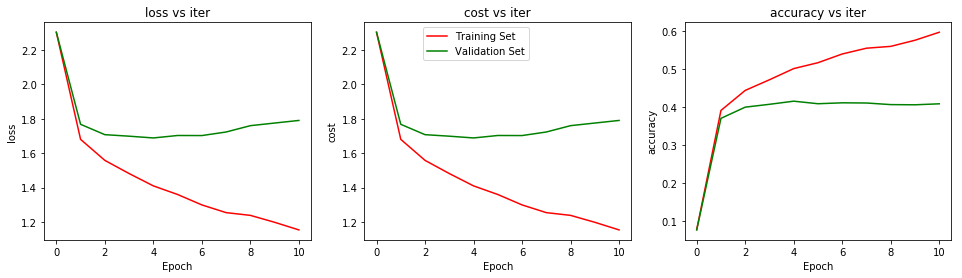

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel\__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


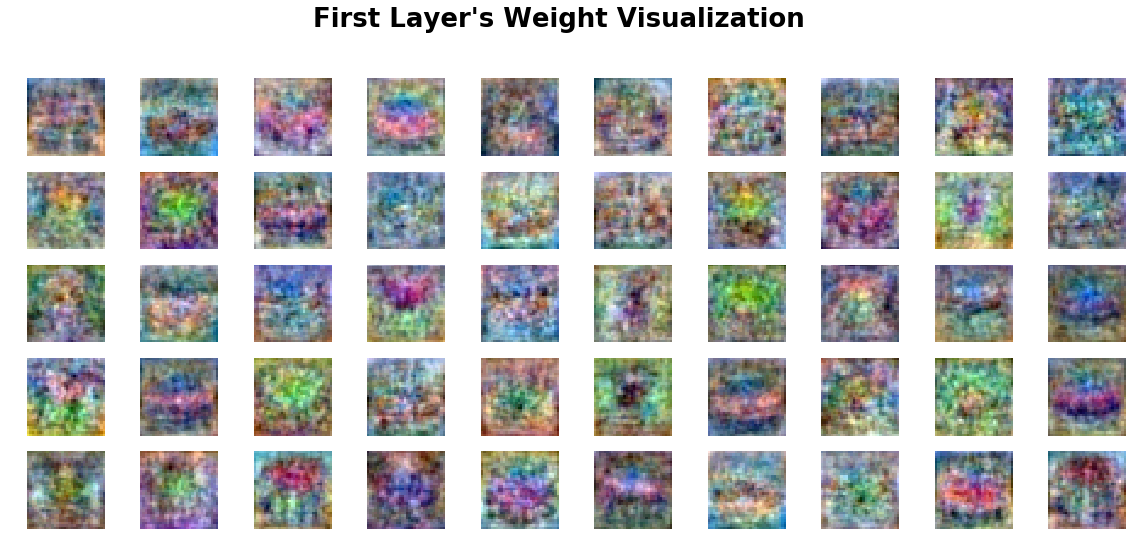

In [11]:
####------>>>>>> ReLu

# #   lamda, n_epochs, n_batch, eta
params=params=GDparams(0, 10, 100, 0.05)   
DropRate= 'on'
EarlyStop= 'on'
UpdateMode = 'Momentum'
Jitter = 'off'
RandOrder = 'off'

#Training--->
newW, newB, L_Train, L_Validation, C_Train, C_Validation, A_Train, A_Validation, BestRun, BestMu, BestVar= MiniBatchGD\
                        (trainingSet, trainingSetLabels, trainingSetLabels_hot, np.copy(OrigW), np.copy(OrigB),\
                                                 validationSet, validationSetLabels, validationSetLabels_hot, params, 'ReLu')
    
# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(A_Train)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(A_Validation)*100)+"%"+" at epoch No %s"%BestRun)
_,_,A_Test=ComputeStats_T(testSet, testSetLabels, testSetLabels_hot, newW, newB, 0, 'ReLu', BestMu, BestVar)
print("The maximum accuracy on Test set is: %s"%(A_Test*100)+"%")

# visualize the learing stats
LearningStats(params,L_Train,L_Validation,C_Train,C_Validation,A_Train,A_Validation,'test')
VisWeights(newW[0],params,'test')

The maximum accuracy on train set is: 58.82%
The maximum accuracy on validation set is: 44.13% at epoch No 4
The maximum accuracy on Test set is: 44.13%


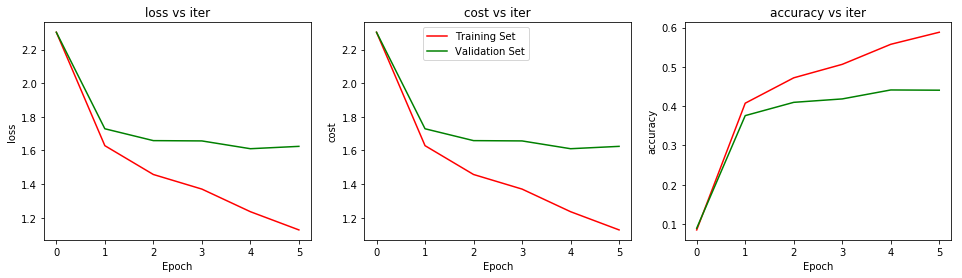

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel\__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


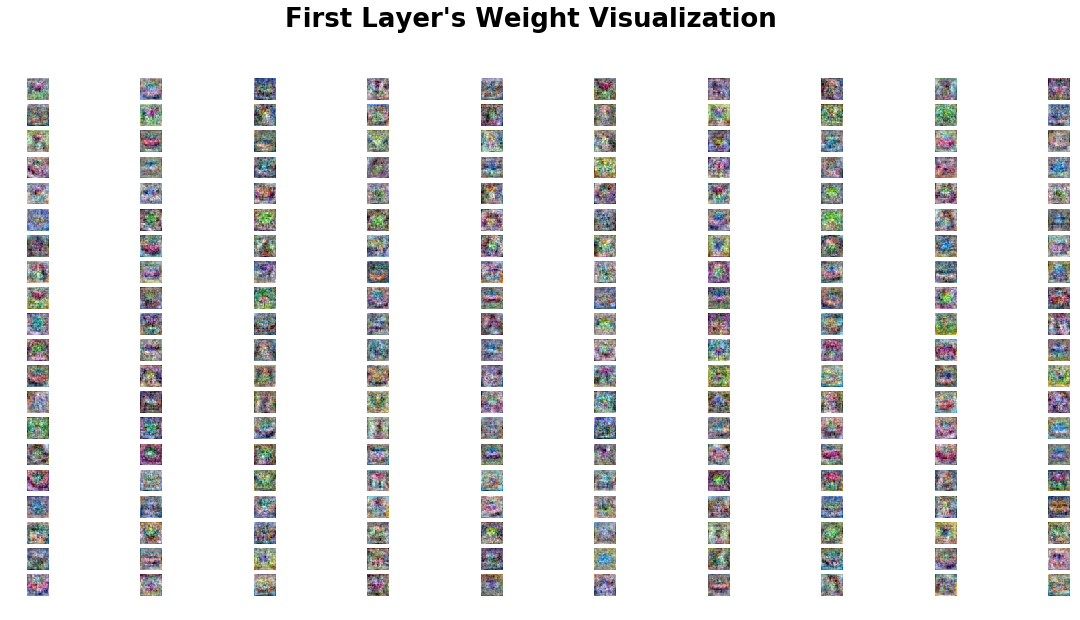

In [23]:
####------>>>>>> LeakyReLu

NetArchitecture=[200,50]
# initialize the weights
OrigW, OrigB =InstallWeights(trainingSet,trainingSetLabels_hot,NetArchitecture)

# #   lamda, n_epochs, n_batch, eta
params=params=GDparams(0, 5, 100, 0.05189)   
DropRate= 'on'
EarlyStop= 'on'
UpdateMode = 'NAG'
Jitter = 'on'
RandOrder = 'on'

#Training--->
newW, newB, L_Train, L_Validation, C_Train, C_Validation, A_Train, A_Validation, BestRun, BestMu, BestVar= MiniBatchGD\
                        (trainingSet, trainingSetLabels, trainingSetLabels_hot, np.copy(OrigW), np.copy(OrigB),\
                                                 validationSet, validationSetLabels, validationSetLabels_hot, params, 'LeakyReLu')
    
# print out learning accuracy
print("The maximum accuracy on train set is: %s"%(np.max(A_Train)*100)+"%")
print("The maximum accuracy on validation set is: %s"%(np.max(A_Validation)*100)+"%"+" at epoch No %s"%BestRun)
_,_,A_Test=ComputeStats_T(testSet, testSetLabels, testSetLabels_hot, newW, newB, 0, 'LeakyReLu', BestMu, BestVar)
print("The maximum accuracy on Test set is: %s"%(A_Test*100)+"%")

# visualize the learing stats
LearningStats(params,L_Train,L_Validation,C_Train,C_Validation,A_Train,A_Validation,'test')
VisWeights(newW[0],params,'test')

In [ ]:
## grid search for ReLu hyperparameters

DropRate= 'on'
EarlyStop= 'off'
UpdateMode = 'Momentum'
Jitter = 'off'
RandOrder = 'off'
bestLamda, bestEta, bestAcc, BigSearchAccuracy, ExtaAccuracy = GridSearch(trainingSet, trainingSetLabels, \
                        trainingSetLabels_hot, np.copy(OrigW), np.copy(OrigB), validationSet, validationSetLabels, validationSetLabels_hot,\
                                                                          'extended', 'ReLu', 2)
## grid search for LeakyReLu hyperparameters
DropRate= 'on'
EarlyStop= 'off'
UpdateMode = 'Momentum'
Jitter = 'off'
RandOrder = 'off'
bestLamda, bestEta, bestAcc, BigSearchAccuracy, ExtaAccuracy = GridSearch(trainingSet, trainingSetLabels, \
                        trainingSetLabels_hot, np.copy(OrigW), np.copy(OrigB), validationSet, validationSetLabels, validationSetLabels_hot,\
                                                                          'extended', 'LeakyReLu', 2)

In [ ]:
# search for ReLu network architecture
DropRate= 'on'
EarlyStop= 'on'
UpdateMode = 'NAG'
Jitter = 'on'
RandOrder = 'on'
SNResults=ArchSearch(trainingSet, trainingSetLabels, trainingSetLabels_hot, validationSet, validationSetLabels,\
           validationSetLabels_hot, 'ReLu',1, 10)


# search for LeakyReLu network architecture
DropRate= 'on'
EarlyStop= 'on'
UpdateMode = 'NAG'
Jitter = 'on'
RandOrder = 'on'
SNResults=ArchSearch(trainingSet, trainingSetLabels, trainingSetLabels_hot, validationSet, validationSetLabels,\
           validationSetLabels_hot, 'LeakyReLu',1, 10)


0.09989999999999999
0.389
0.40190000000000003
0.44399999999999995
0.45399999999999996
0.4357
0.44089999999999996
0.45389999999999997
0.4506
0.45309999999999995
0.09989999999999999
0.38849999999999996
0.40249999999999997
0.4204
0.42989999999999995
0.43279999999999996
0.44220000000000004
0.4516
0.4478
0.4373
0.09989999999999999
0.38949999999999996
0.40480000000000005
0.4266
0.4416
0.44710000000000005
0.44899999999999995
0.44279999999999997
0.44789999999999996
0.44389999999999996
0.09989999999999999
0.3899
0.401
0.41910000000000003
0.41390000000000005
0.4334
